In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import Sequential
from keras import layers
import os
from keras.preprocessing import image

## Resampled model

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range = 360
# )



# train_generator = datagen.flow_from_directory(
#         'sampled_classes/train/',
#         target_size=(180, 180),
#         batch_size=32,
#         class_mode='categorical')


# val_generator = datagen.flow_from_directory(
#         'sampled_classes/validation/',
#         target_size=(180, 180),
#         batch_size=32,
#         class_mode='categorical')

Found 525 images belonging to 7 classes.
Found 175 images belonging to 7 classes.


In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/train/', 
  labels='inferred',
  label_mode='categorical', 
  seed=123, 
  batch_size=32, 
  image_size=(180, 180)
)
  
val_ds = keras.preprocessing.image_dataset_from_directory(
  './sampled_classes/validation/', 
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 2625 files belonging to 7 classes.


2022-05-20 10:28:45.180693: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 875 files belonging to 7 classes.


In [5]:
model = Sequential([
    layers.RandomRotation(factor=1, input_shape=(180, 180, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(7, activation='softmax'),
])

In [6]:
model.compile(
    optimizer='adam',
    loss = keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

In [7]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_categorical_accuracy", 
                                        mode ="max", 
                                        patience = 8, 
                                        restore_best_weights = True,
                                        verbose=2)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=36,
    callbacks=earlystopping
)

Epoch 1/36


2022-05-20 10:29:02.681850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


83/83 [==============================] - 131s 2s/step - loss: 1.9742 - categorical_accuracy: 0.2030 - val_loss: 1.8387 - val_categorical_accuracy: 0.2834
Epoch 2/36
83/83 [==============================] - 139s 2s/step - loss: 1.6899 - categorical_accuracy: 0.3398 - val_loss: 1.5691 - val_categorical_accuracy: 0.3977
Epoch 3/36
83/83 [==============================] - 120s 1s/step - loss: 1.5286 - categorical_accuracy: 0.4019 - val_loss: 1.4555 - val_categorical_accuracy: 0.4286
Epoch 4/36
83/83 [==============================] - 133s 2s/step - loss: 1.4394 - categorical_accuracy: 0.4370 - val_loss: 1.3745 - val_categorical_accuracy: 0.4526
Epoch 5/36
83/83 [==============================] - 91s 1s/step - loss: 1.3954 - categorical_accuracy: 0.4434 - val_loss: 1.3892 - val_categorical_accuracy: 0.4811
Epoch 6/36
83/83 [==============================] - 85s 1s/step - loss: 1.3674 - categorical_accuracy: 0.4670 - val_loss: 1.3463 - val_categorical_accuracy: 0.4709
Epoch 7/36
83/83 [=====

In [9]:
model.save(
    './models/model',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)


2022-05-20 11:24:40.206537: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/model/assets


### evaluation

#### loss curve

In [10]:
def plot_acc(history, epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

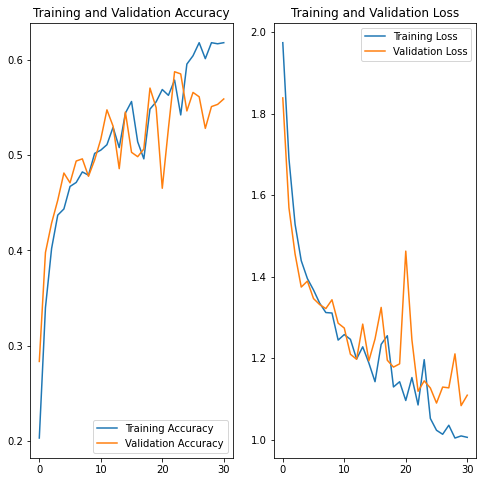

In [11]:
plot_acc(history, 31)

#### confusion matrix

In [35]:
y_true = []
y_pred = []
for images, labels in val_ds:
    y_pred.append(np.argmax(model.predict(images), axis=1))
    y_true.append(np.argmax(labels,axis=1))


In [36]:
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
# print(y_true)
# print(y_pred)

In [28]:
m = keras.metrics.CategoricalAccuracy()
m.update_state(y_true, y_pred)
m.result().numpy()

1.0

In [25]:
# list(map(lambda x: cls[x], pred_2))

In [26]:
from sklearn.metrics import confusion_matrix

In [37]:
conf = confusion_matrix(y_true, y_pred)
conf

array([[ 54,  17,   6,  39,   4,   5,   0],
       [ 30,  65,   1,  23,   1,   1,   4],
       [ 23,  10,  38,  13,  17,  19,   5],
       [ 17,   6,   0,  97,   2,   3,   0],
       [  7,  11,  14,   6,  66,  17,   4],
       [  4,   3,  12,   7,  16,  82,   1],
       [  0,   9,   0,   4,   0,   0, 112]])

In [38]:
diag = 0
for i in range(7):
    diag += conf[i][i]
diag/conf.sum()

0.5874285714285714

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.43      0.42       125
           1       0.54      0.52      0.53       125
           2       0.54      0.30      0.39       125
           3       0.51      0.78      0.62       125
           4       0.62      0.53      0.57       125
           5       0.65      0.66      0.65       125
           6       0.89      0.90      0.89       125

    accuracy                           0.59       875
   macro avg       0.59      0.59      0.58       875
weighted avg       0.59      0.59      0.58       875



#### Prediction

In [42]:
cls = train_ds.class_names

In [40]:
img = keras.utils.load_img(
    './uploads/1.1.jpg',
    target_size=(180,180)
)
img = keras.preprocessing.image.img_to_array(img)
img = np.array([img])

In [43]:
cls[np.argmax(model.predict(img))]

'bcc'

In [45]:
np.round(model.predict(img),2)

array([[0.02, 0.65, 0.28, 0.01, 0.01, 0.03, 0.01]], dtype=float32)